# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

from injectio import pharma, fit

## Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [2]:
sine_target_func = lambda T: int(T>=31.0) * (250.0 + 50.0*np.sin(0.5*T + 9.59)) +\
                             int(T<31.0)  * (8.0*T)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(62.0, unit='D'), freq='6H')
sine_target_y = np.array([sine_target_func(pharma.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

In [3]:
sine_results = fit.emptyResults()

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [4]:
sine_results["ec_doses"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 62.0, '3D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='fixed')
fit.runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1512e+05                                    3.64e+05    
       1              2         1.5695e+05      5.58e+05       8.84e-01       1.37e+05    
       2              3         6.6711e+04      9.02e+04       5.85e-01       4.85e+04    
       3              4         5.1118e+04      1.56e+04       2.89e-01       1.39e+05    
       4              5         4.6252e+04      4.87e+03       1.18e-01       6.43e+04    
       5              6         3.0809e+04      1.54e+04       5.45e-01       1.14e+05    
       6              7         2.7486e+04      3.32e+03       9.15e-02       2.26e+04    
       7              8         2.3201e+04      4.28e+03       1.66e-01       7.87e+04    
       8              9         2.1972e+04      1.23e+03       7.34e-02       2.40e+04    
       9             10         1.9300e+04      2.67e+03       1.86e-01       7.14e+04    

Optimized Injections:
                  dose injectable
2020-01-01      0.350         ec
2020-01-04      0.375         ec
2020-01-07      0.450         ec
2020-01-10      0.544         ec
2020-01-13      0.615         ec
2020-01-16      0.689         ec
2020-01-19      0.789         ec
2020-01-22      0.811         ec
2020-01-25      0.888         ec
2020-01-28      1.008         ec
2020-01-31      1.603         ec
2020-02-03      0.487         ec
2020-02-06      0.142         ec
2020-02-09      0.645         ec
2020-02-12      2.037         ec
2020-02-15      0.573         ec
2020-02-18      0.136         ec
2020-02-21      0.464         ec
2020-02-24      1.966         ec
2020-02-27      0.981         ec
2020-03-01      0.585         ec
2020-03-04      0.000         ec


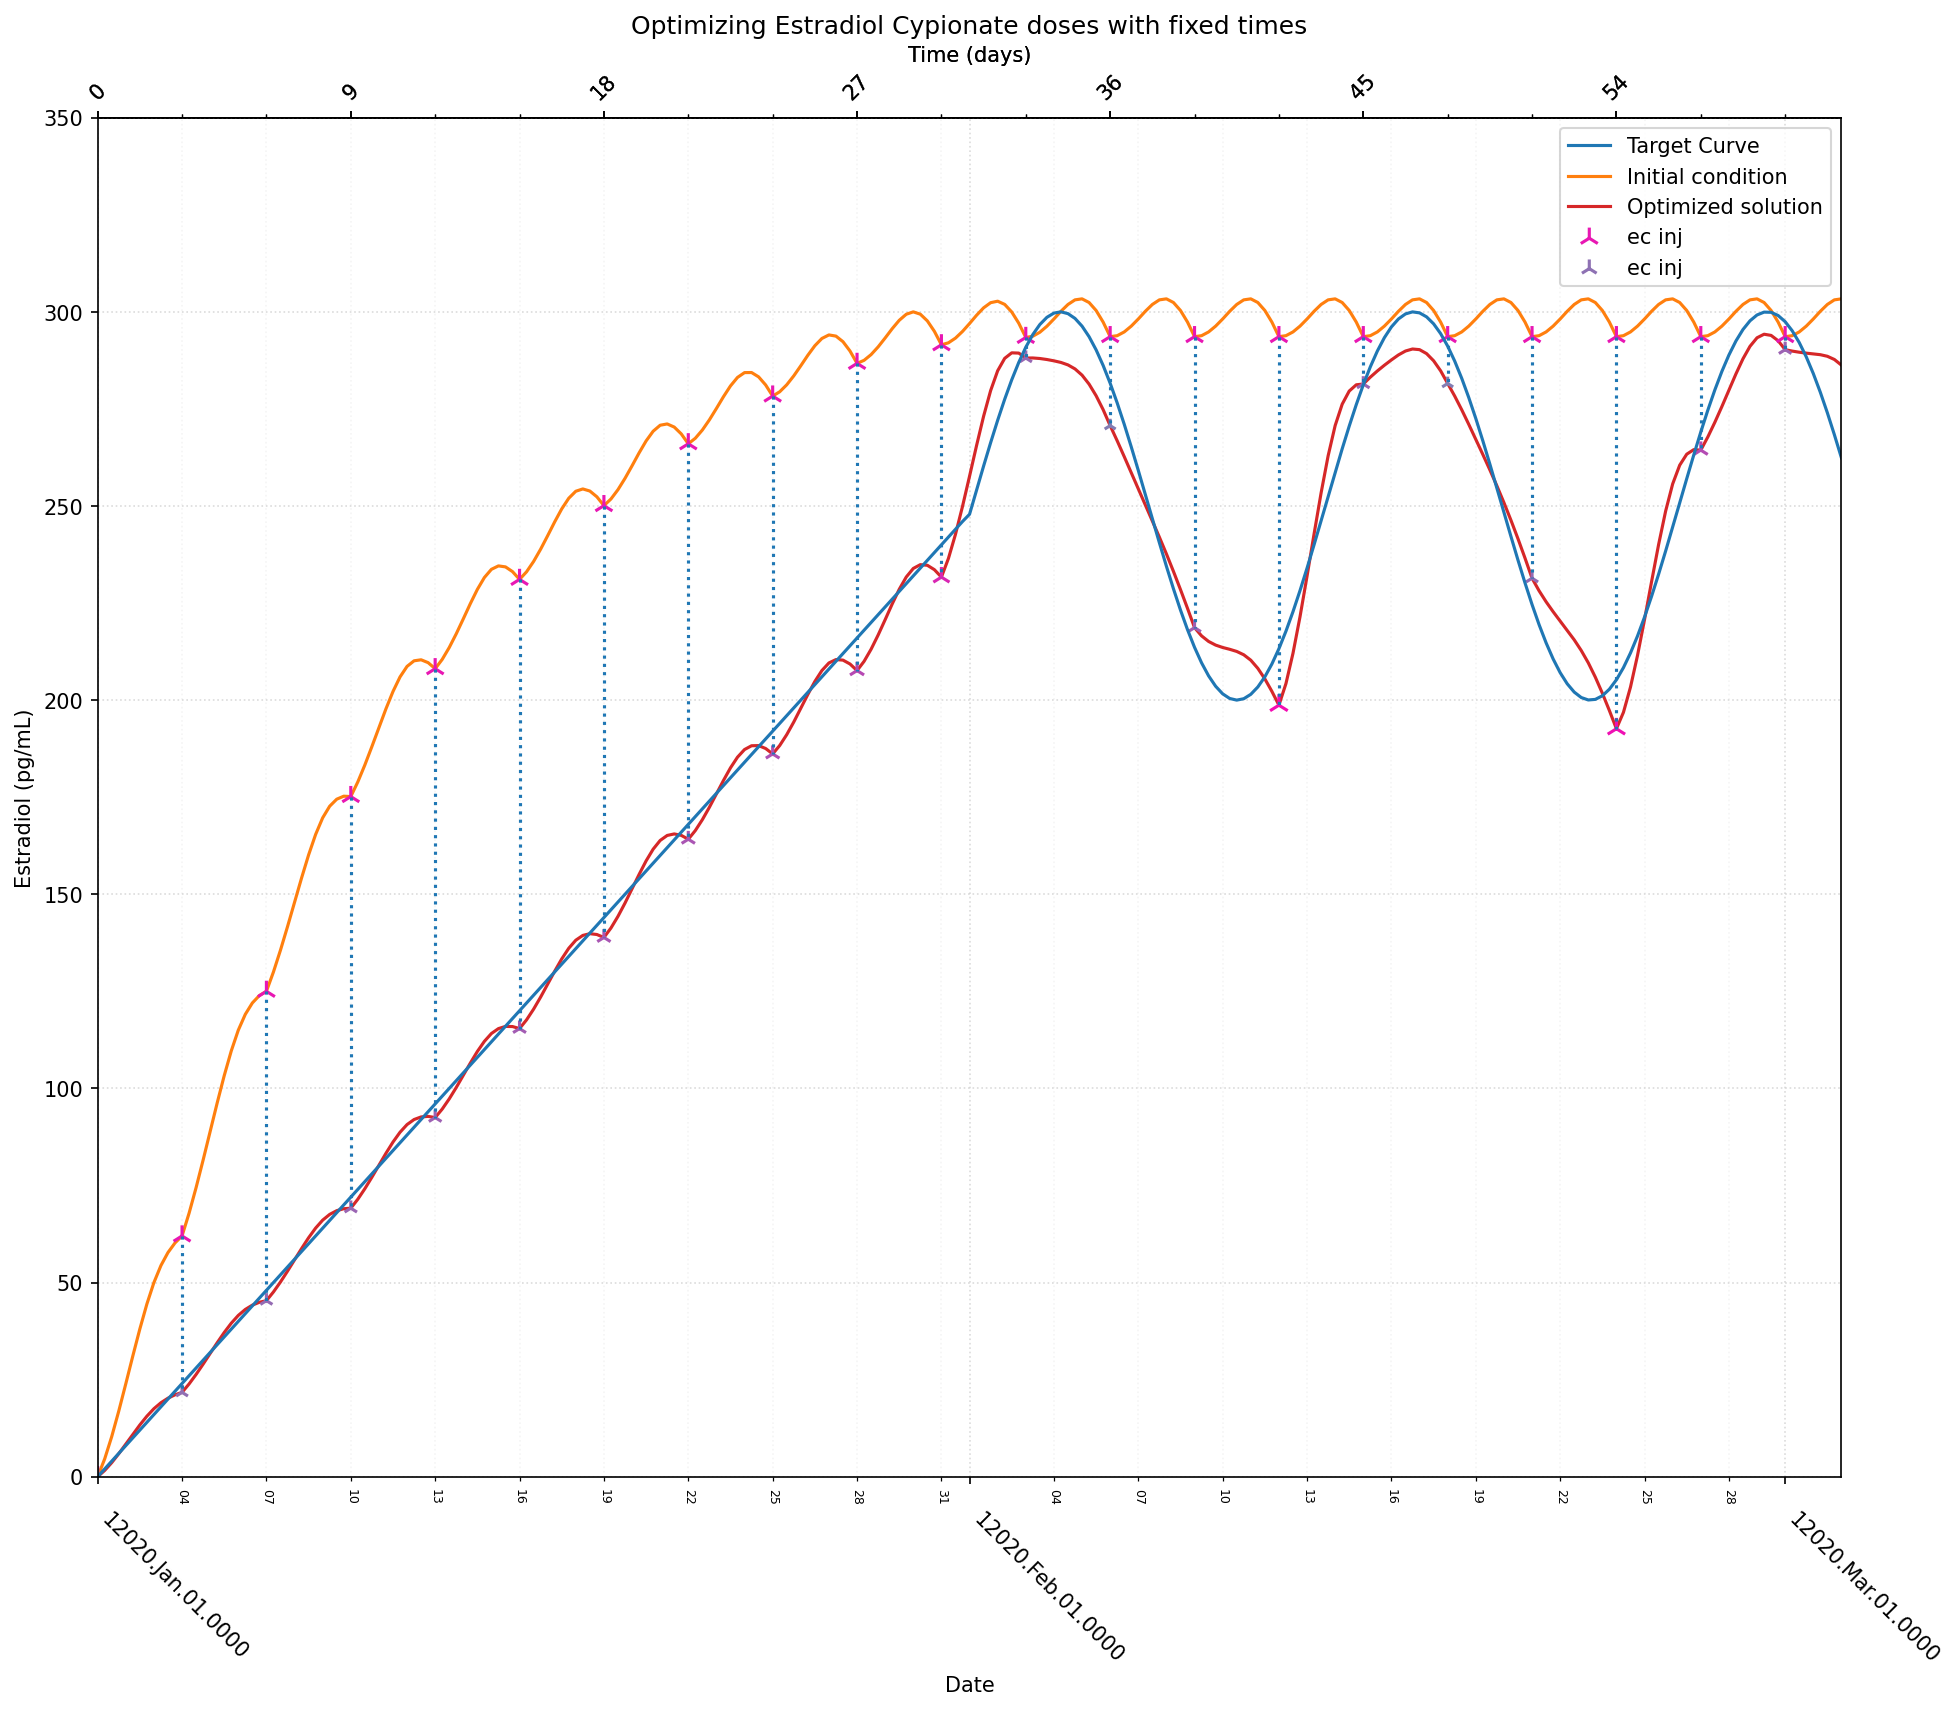

In [6]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses with fixed times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses"]["injections_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [67]:
sine_results["ec_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 62.0, '3D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    sine_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=30,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1326e+05                                    3.64e+05    
       1              2         1.5722e+05      5.56e+05       8.84e-01       1.33e+05    
       2              3         6.2393e+04      9.48e+04       6.31e-01       4.50e+04    
       3              4         4.7266e+04      1.51e+04       2.55e-01       1.59e+05    
       4              5         3.3380e+04      1.39e+04       1.16e+00       1.42e+05    
       5              6         2.9351e+04      4.03e+03       1.05e-01       5.53e+04    
       6              7         2.0826e+04      8.53e+03       3.72e-01       7.01e+04    
       7              8         6.8378e+03      1.40e+04       1.68e+00       2.20e+04    
       8              9         2.1177e+03      4.72e+03       1.59e+00       1.52e+04    
       9             10         1.5409e+03      5.77e+02       2.73e-01       1.12e+04    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      0.360         ec
2020-01-04 04:59:29.986166400      0.414         ec
2020-01-07 09:52:10.399353600      0.478         ec
2020-01-10 11:38:55.338230400      0.567         ec
2020-01-13 10:57:05.229360000      0.626         ec
2020-01-16 09:57:18.551952000      0.690         ec
2020-01-19 08:14:47.801270400      0.746         ec
2020-01-22 05:16:08.513817600      0.815         ec
2020-01-25 02:33:43.561238400      0.875         ec
2020-01-27 22:04:30.540633600      0.941         ec
2020-01-30 19:39:34.989494400      1.180         ec
2020-02-01 19:27:51.674832000      1.033         ec
2020-02-07 12:00:00.000000000      0.006         ec
2020-02-09 20:26:42.227577600      1.038         ec
2020-02-12 00:43:57.541612800      1.401         ec
2020-02-14 04:29:16.554624000      0.937         ec
2020-02-16 12:02:56.949187199      0.000         ec
2020-02-22 04:00:18.101347200      1.044 

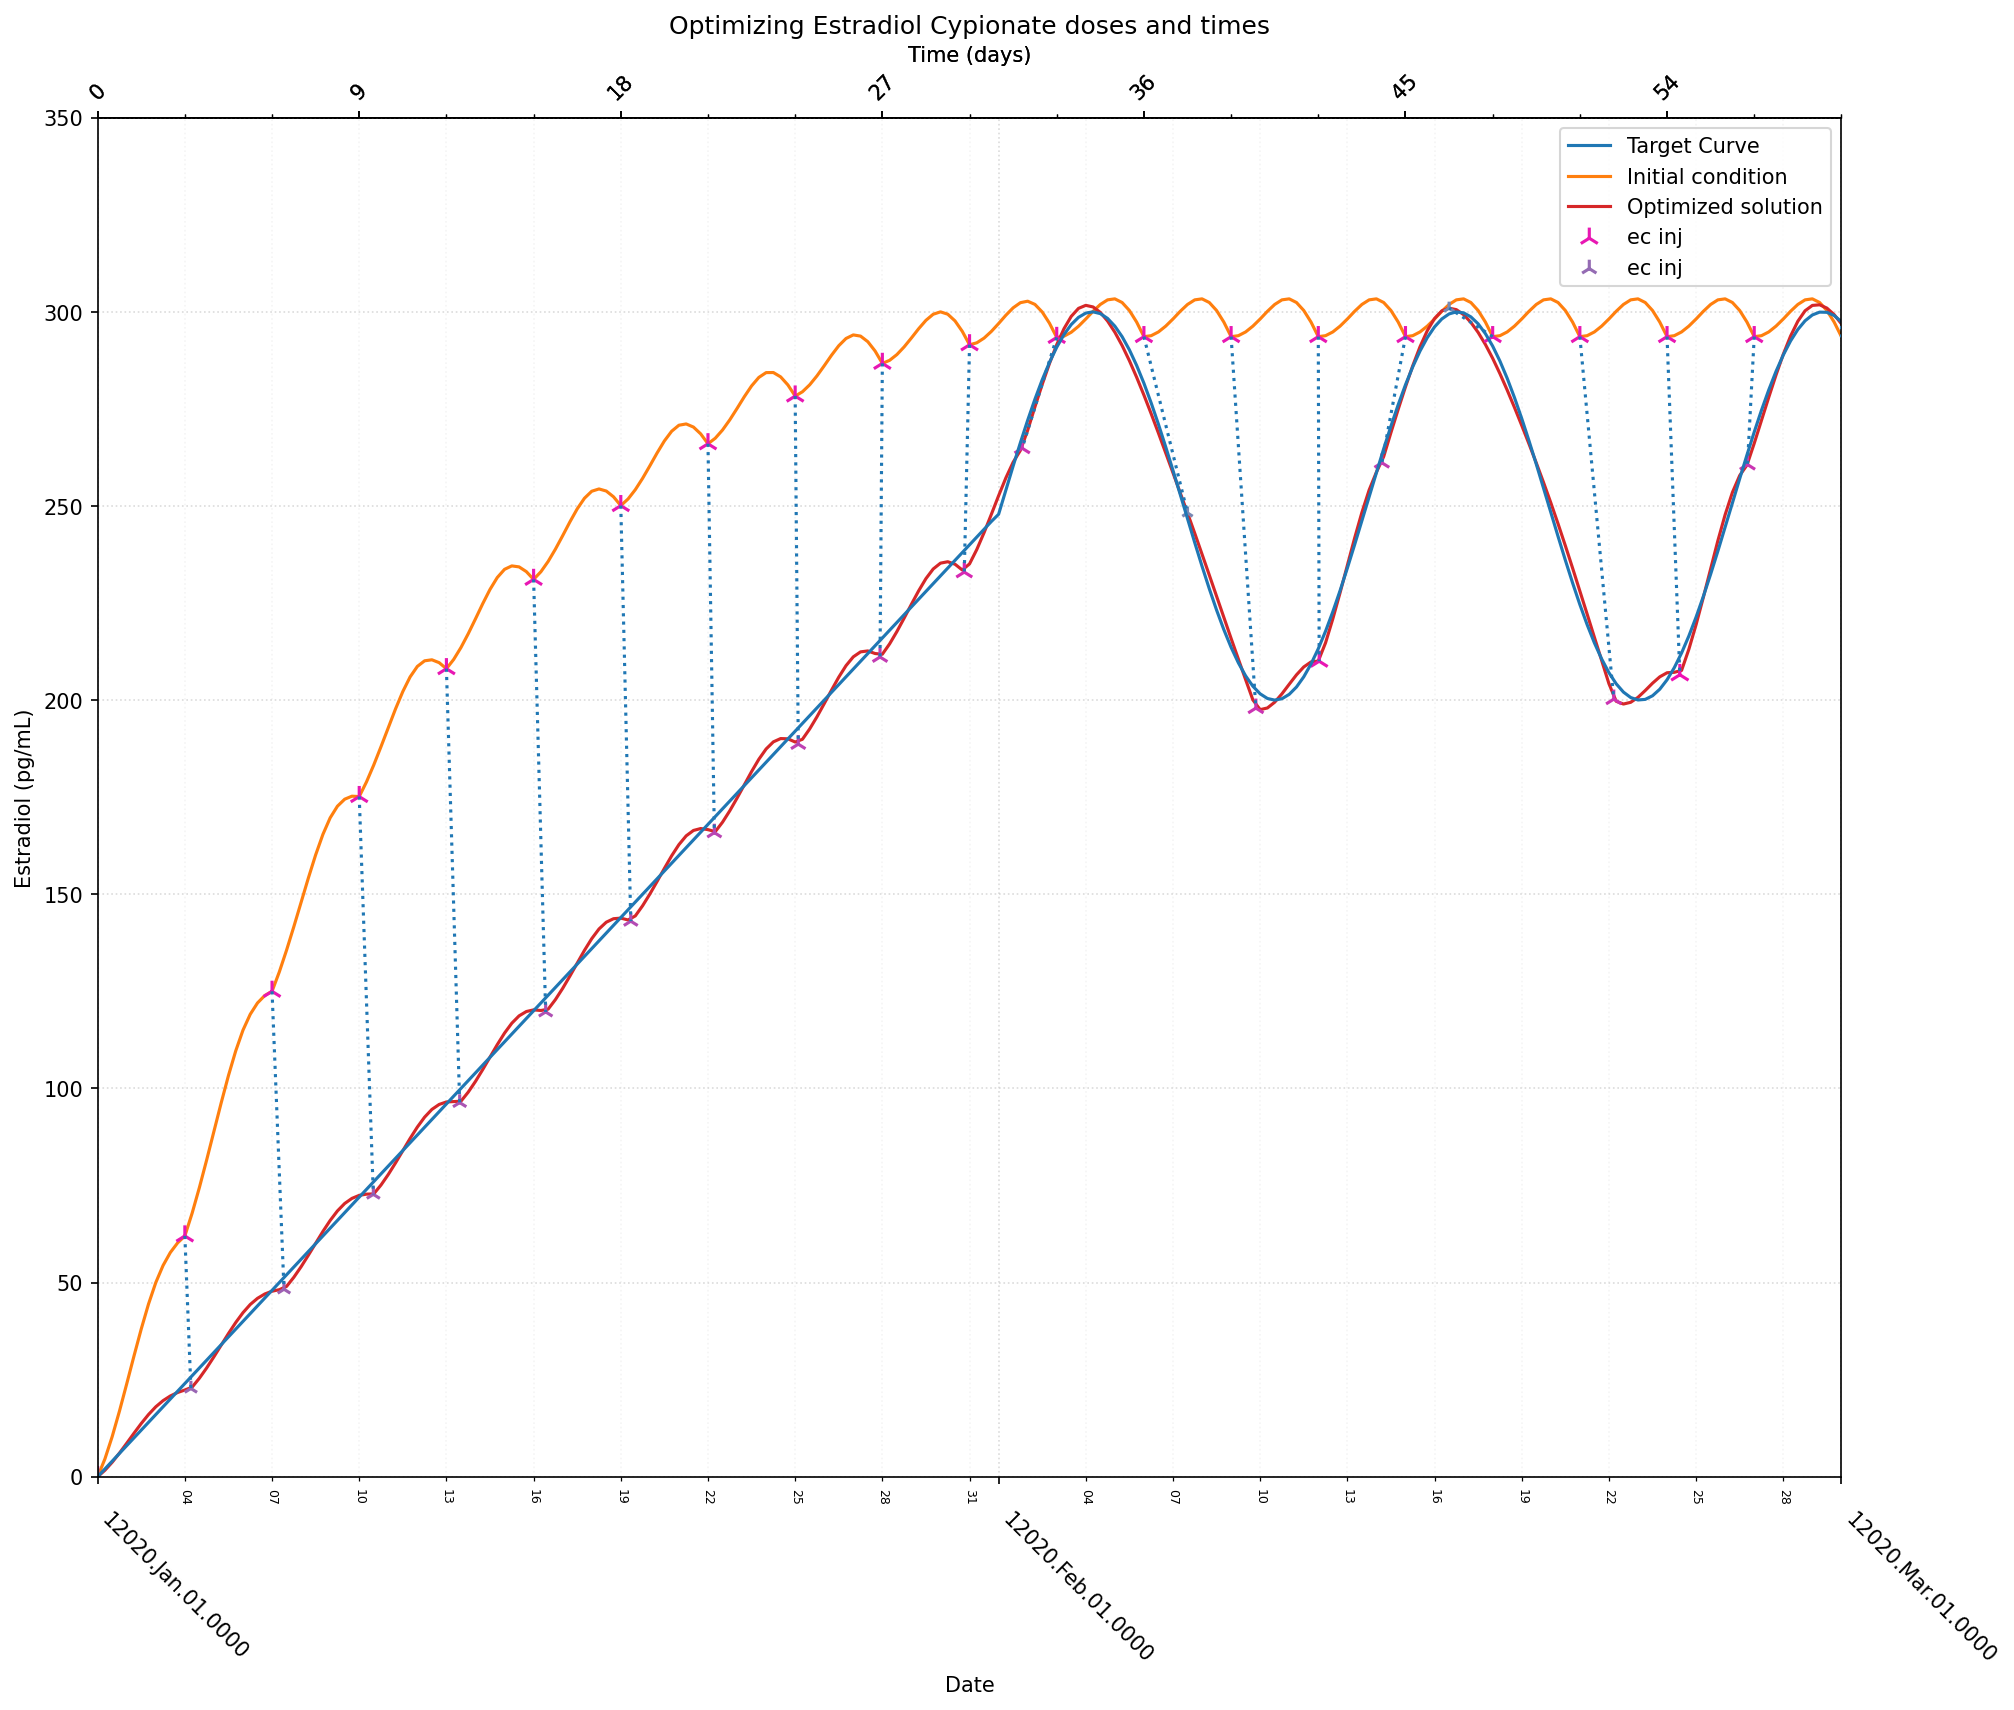

In [82]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses_and_times"]["injections_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [84]:
sine_results["ev_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ev", 62.0, '1D', start_date="2020"),
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2826e+06                                    7.29e+05    
       1              2         1.5084e+06      7.77e+06       2.79e+00       1.78e+05    
       2              3         1.9838e+05      1.31e+06       1.29e+00       5.94e+04    
       3              4         2.7900e+04      1.70e+05       5.27e-01       7.63e+04    
       4              5         2.2354e+04      5.55e+03       1.40e-01       1.62e+04    
       5              6         7.7297e+03      1.46e+04       1.78e-01       4.99e+04    
       6              7         4.3732e+03      3.36e+03       1.37e+00       3.16e+04    
       7              8         3.7305e+03      6.43e+02       4.07e-02       6.10e+03    
       8              9         1.9593e+03      1.77e+03       8.33e-02       1.38e+04    
       9             10         6.5607e+02      1.30e+03       1.14e+00       6.42e+03    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      0.116         ev
2020-01-02 09:41:24.632707200      0.074         ev
2020-01-03 04:00:15.948950400      0.081         ev
2020-01-04 07:32:57.439334400      0.143         ev
2020-01-05 11:59:56.020070400      0.157         ev
2020-01-06 11:45:32.671353600      0.075         ev
2020-01-06 17:15:40.053312000      0.107         ev
2020-01-07 16:56:54.795264000      0.154         ev
2020-01-08 16:17:43.186243200      0.202         ev
2020-01-09 14:22:42.887481600      0.166         ev
2020-01-10 14:48:10.445961600      0.268         ev
2020-01-11 21:51:45.557971200      0.319         ev
2020-01-13 04:27:47.340057599      0.336         ev
2020-01-14 09:48:31.038393600      0.293         ev
2020-01-14 22:42:22.396233600      0.114         ev
2020-01-15 19:20:30.419059200      0.357         ev
2020-01-17 00:44:23.522870400      0.404         ev
2020-01-18 04:01:12.330566400      0.310 

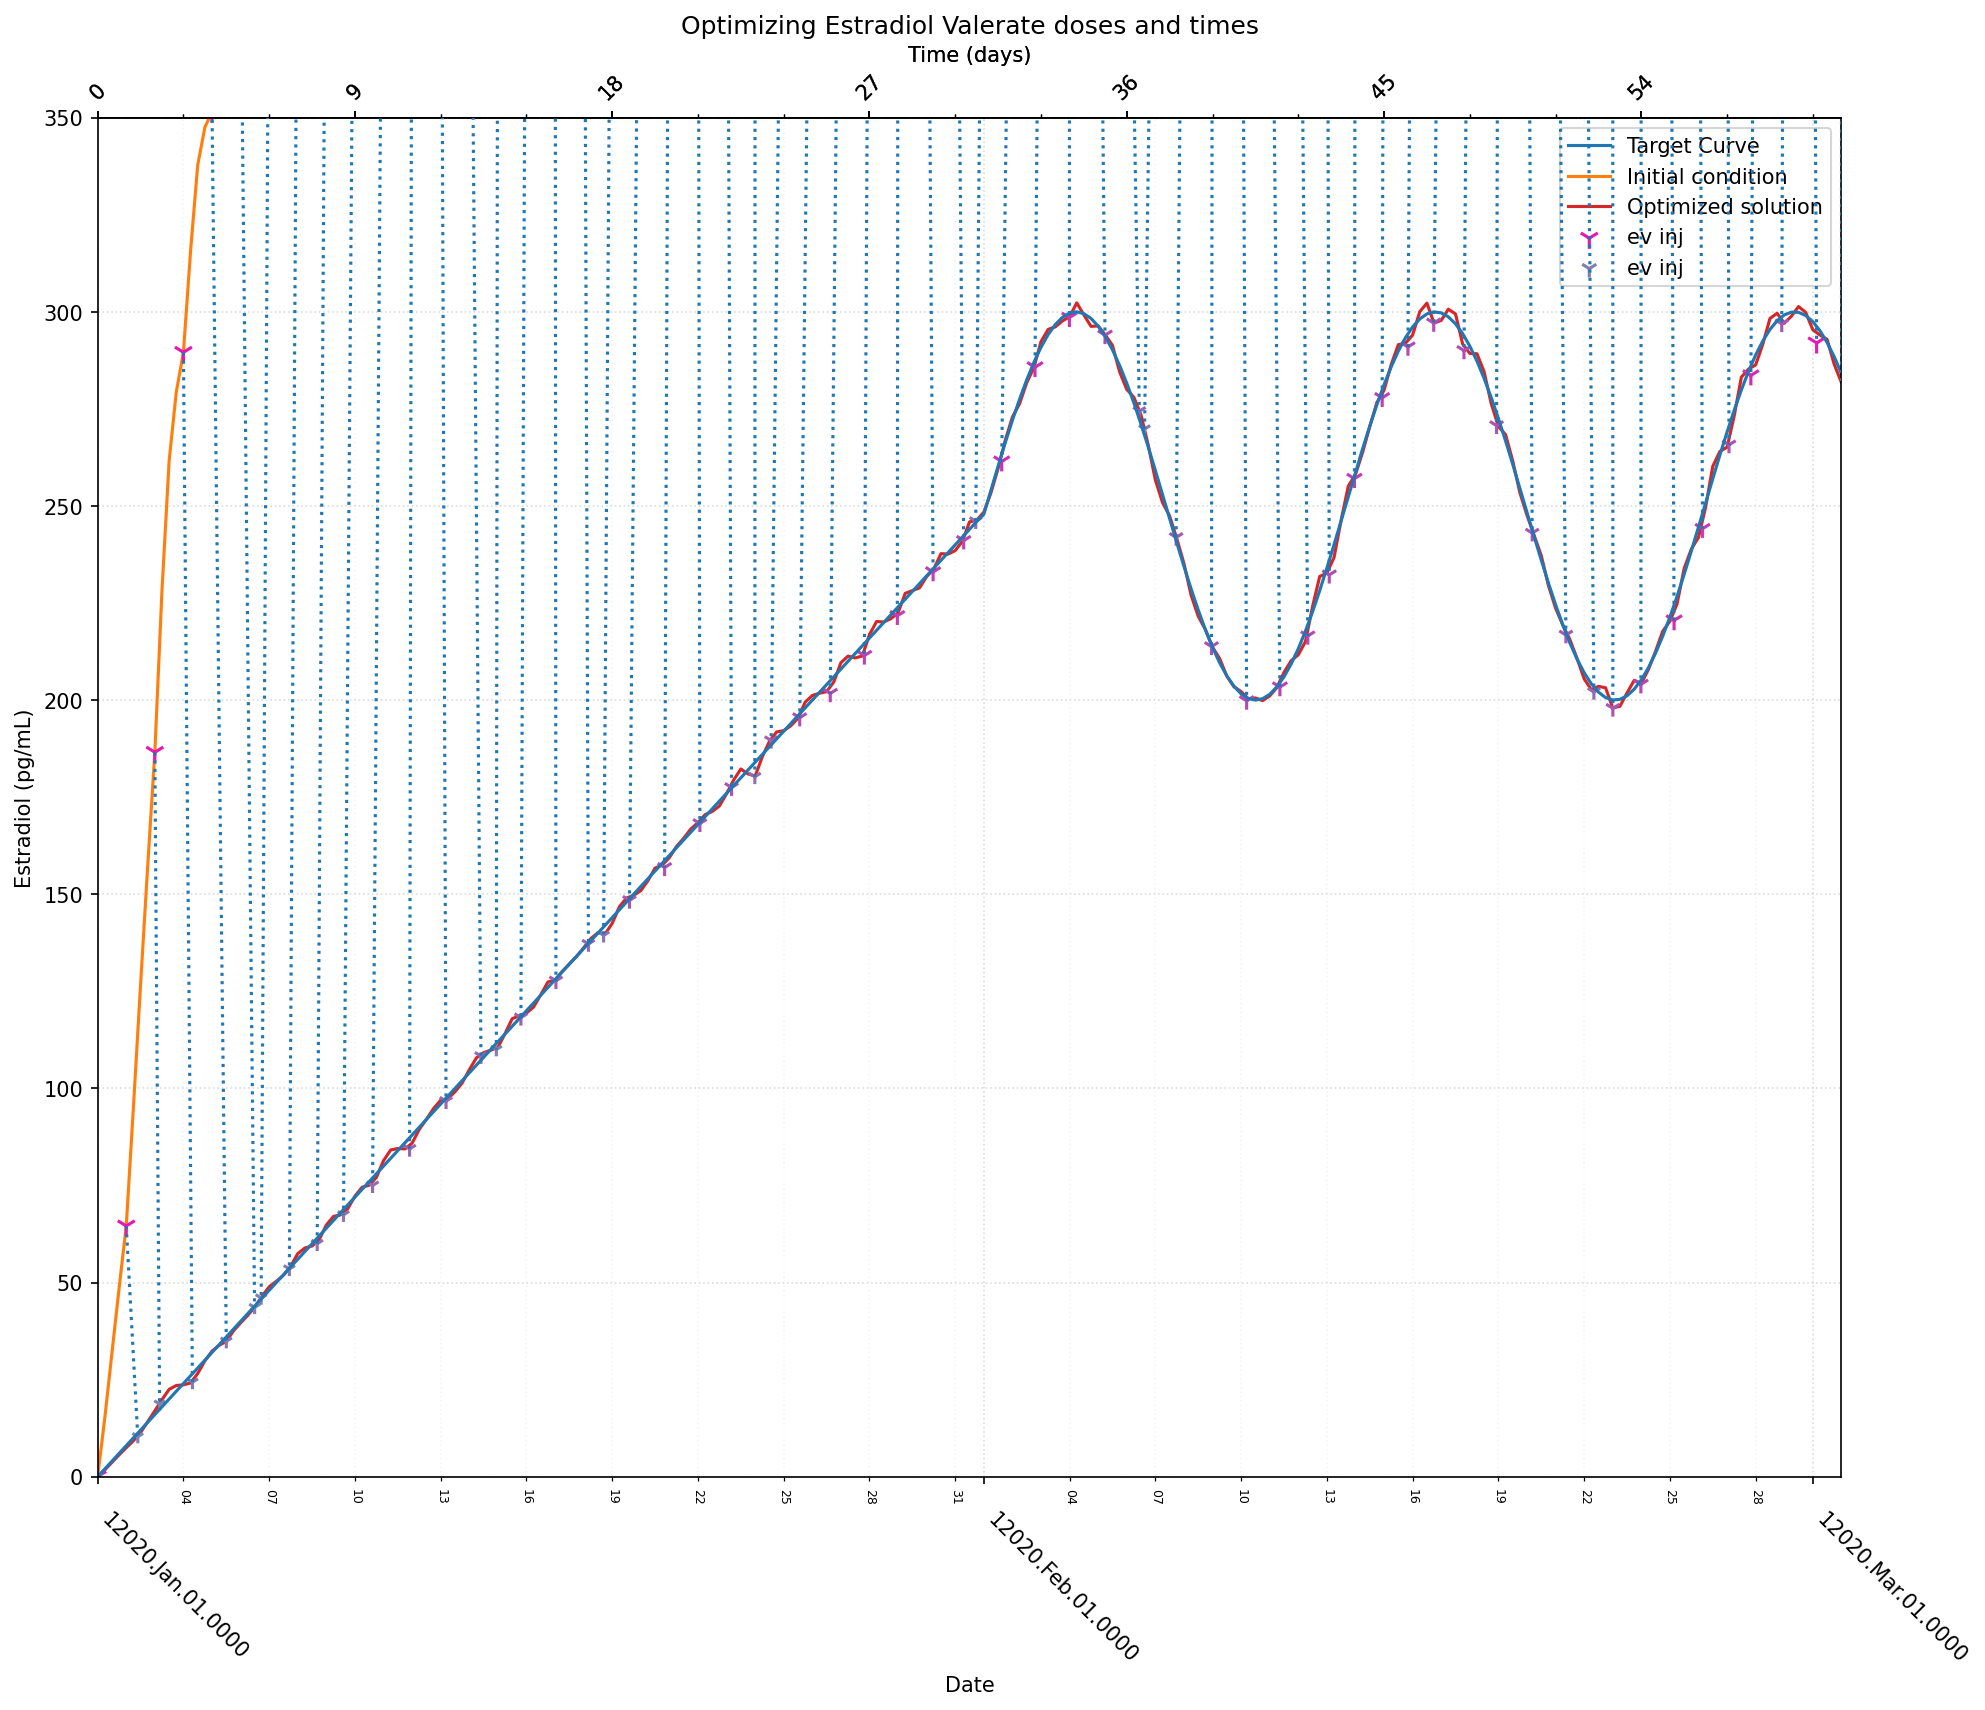

In [85]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Injections:\n", sine_results["ev_doses_and_times"]["injections_optim"])

### Step func (Estradiol Cypionate, optimize doses & times)

It's fun! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [86]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
step_target_y = np.array([step_func(T) for T in step_target_x])

In [87]:
step_results = fit.emptyResults()

In [88]:
step_results["ec_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 62.0, '3D'),
    step_target_x, step_target_y,
    max_dose=1.5,
    time_bounds='midpoints')
fit.runLeastSquares(
    step_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3324e+06                                    5.22e+05    
       1              2         2.8834e+05      1.04e+06       1.10e+00       1.20e+05    
       2              3         1.3298e+05      1.55e+05       5.00e-01       5.47e+04    
       3              4         8.4492e+04      4.85e+04       4.35e-01       3.37e+04    
       4              5         7.4254e+04      1.02e+04       2.10e-01       1.92e+04    
       5              6         6.7087e+04      7.17e+03       1.63e-01       1.67e+04    
       6              7         6.3290e+04      3.80e+03       1.23e-01       1.22e+04    
       7              8         5.9641e+04      3.65e+03       1.26e-01       1.43e+04    
       8              9         5.7430e+04      2.21e+03       9.08e-02       9.80e+03    
       9             10         5.5026e+04      2.40e+03       1.13e-01       1.27e+04    

Optimized Injections:
                                     dose injectable
1970-01-01 00:00:00.000000000      1.485         ec
1970-01-03 17:51:52.166073600      0.145         ec
1970-01-07 01:23:45.262809600      0.234         ec
1970-01-10 00:27:22.556361599      0.413         ec
1970-01-12 22:09:44.779161600      0.344         ec
1970-01-16 00:20:13.740979200      0.285         ec
1970-01-18 23:19:25.568112000      0.293         ec
1970-01-22 02:03:59.275007999      0.303         ec
1970-01-25 03:34:15.658262400      0.328         ec
1970-01-29 05:51:57.445545600      1.244         ec
1970-01-30 19:06:50.827881600      1.492         ec
1970-02-02 10:20:51.811612800      0.723         ec
1970-02-06 02:21:11.551363200      0.817         ec
1970-02-08 23:18:24.669763200      0.936         ec
1970-02-11 21:24:28.618905600      0.813         ec
1970-02-15 00:01:31.651392000      0.755         ec
1970-02-18 00:11:20.145292799      0.800         ec
1970-02-21 01:04:19.968902400      0.828 

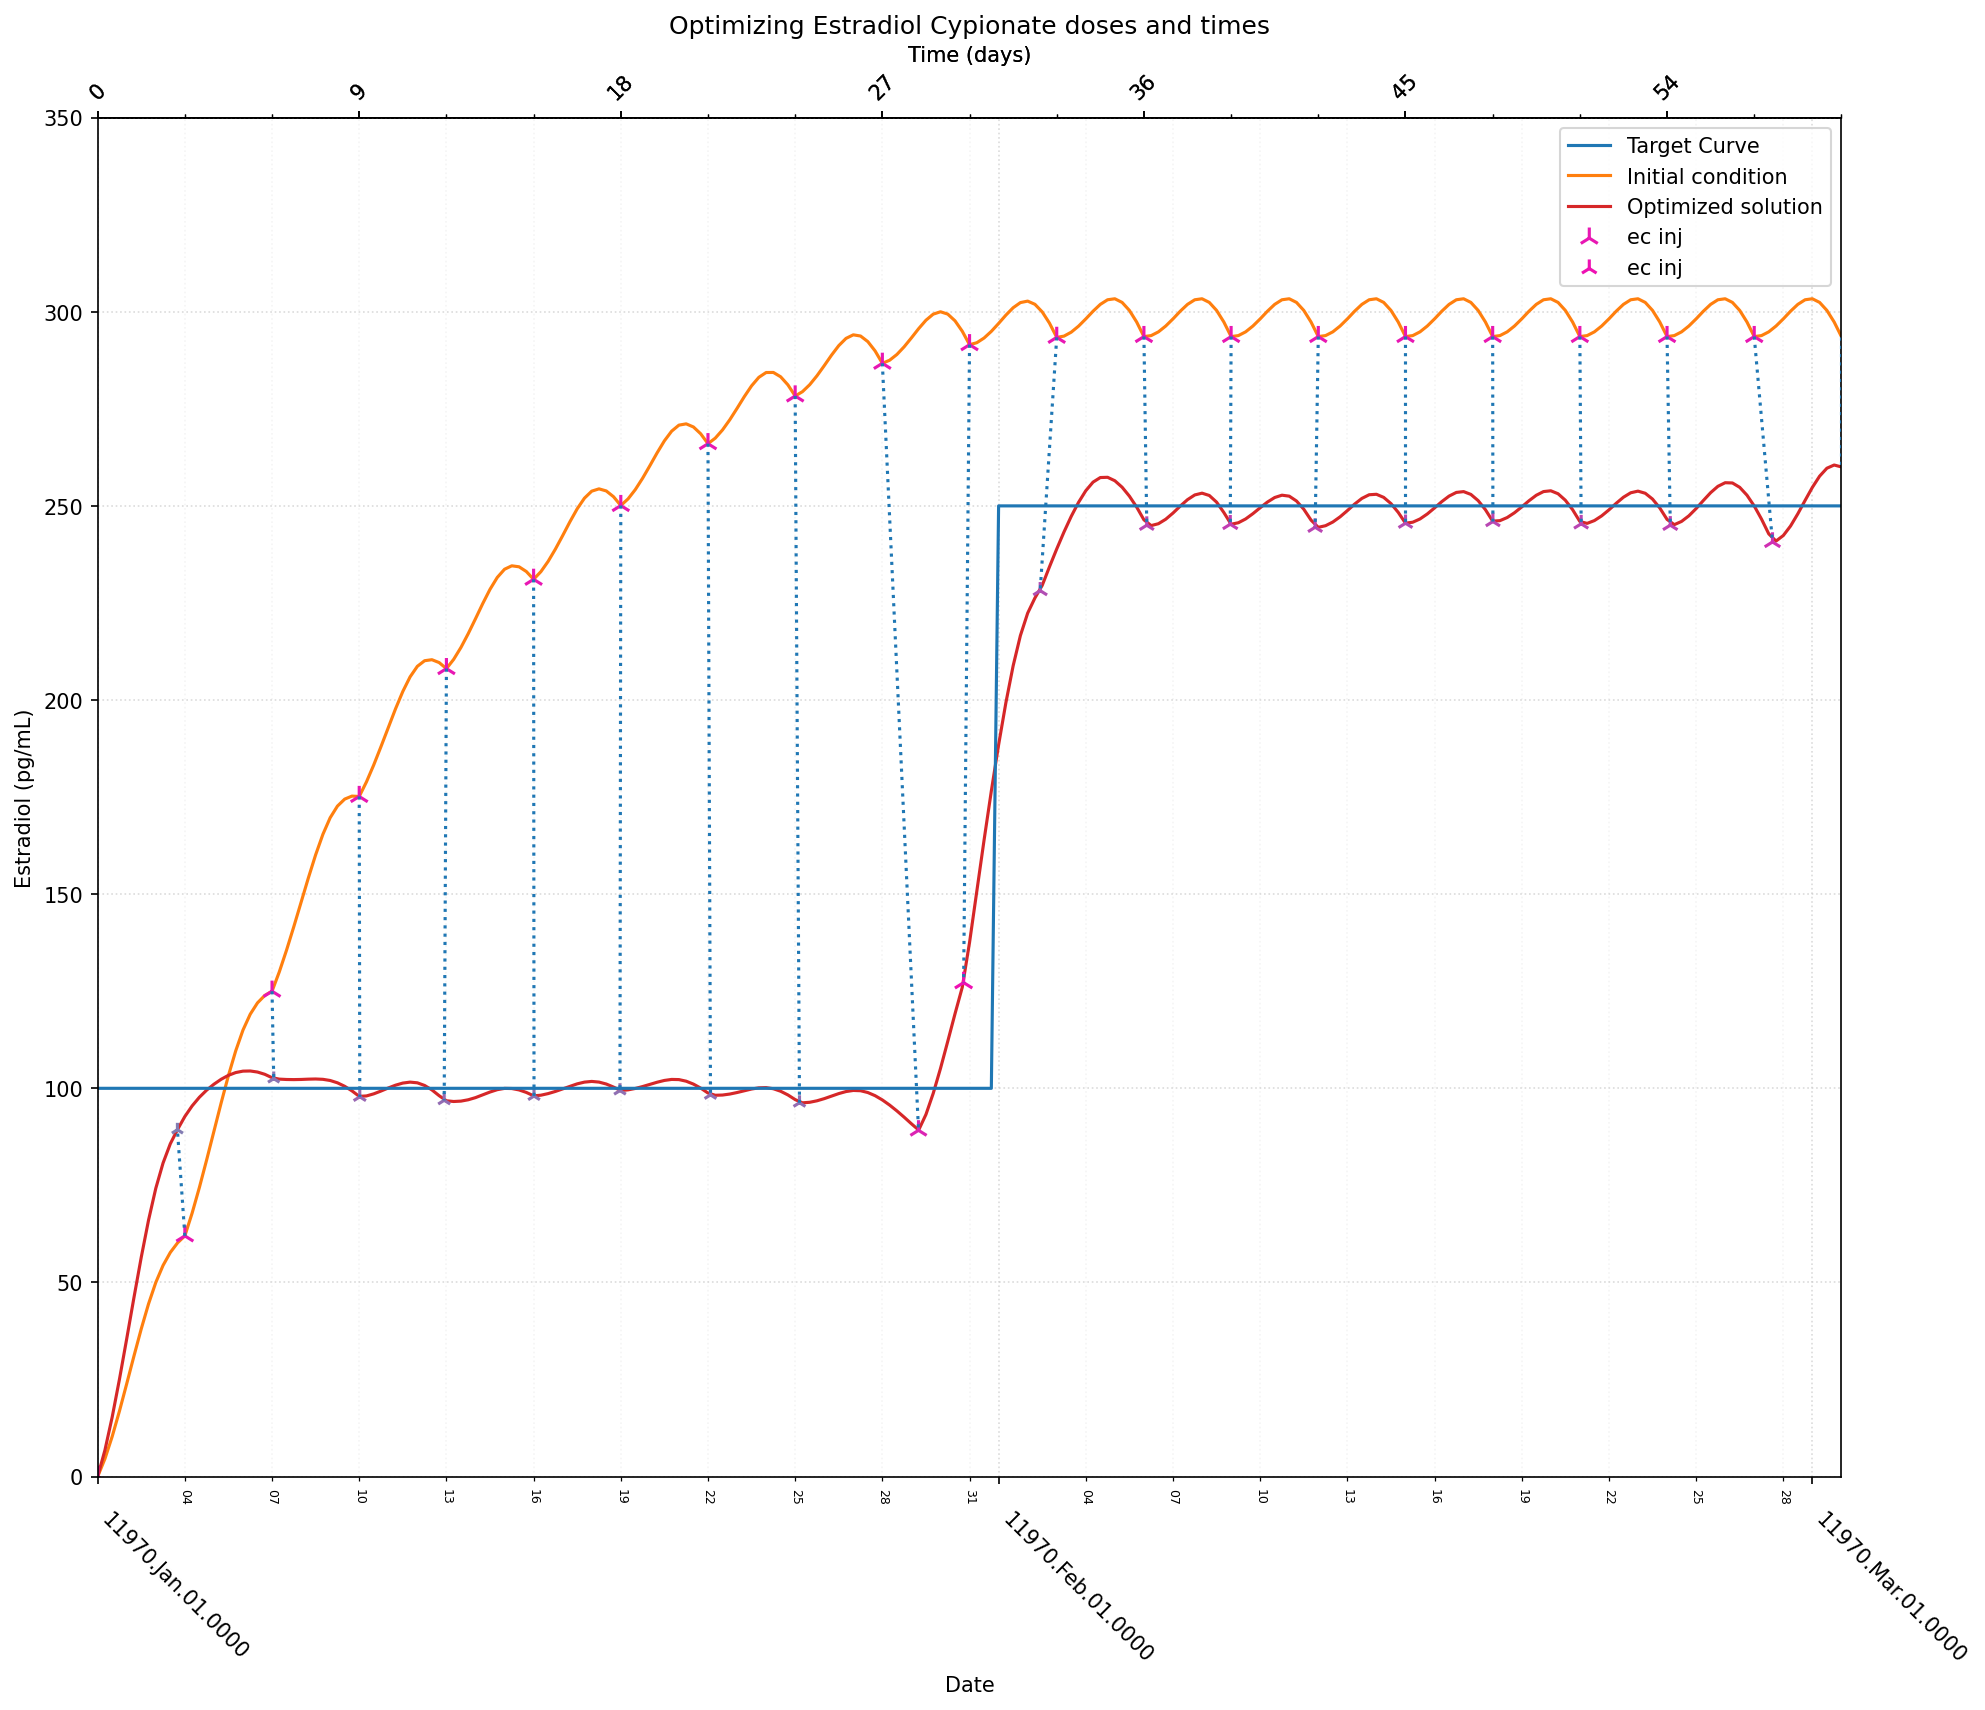

In [89]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", step_results["ec_doses_and_times"]["injections_optim"])